<a href="https://colab.research.google.com/github/dmdiegoar/Quant-code-t0/blob/main/Asset_data_download_TV%2C_Matriz%2C_YF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wrapper principal

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime

Métodos para traer datos de TV

In [2]:
import re
import random
import string
import json
import pandas as pd
from datetime import datetime
from websocket import create_connection

In [4]:
def get_ticker_wrapper(ticker, download=True, start_date='1999-01-01', timeframe='D'):
    """
    Obtiene datos de precios de acciones para un ticker dado, con opciones para descargar y ajustar según el ticker.

    Args:
        ticker (str): Símbolo del ticker de la acción. (prefijo "tv:" para forzar usar tradingview como source. cualquier ticker con prefijo "bm_" va a usar matriz como source)
                      /CER o /CCL va a ajustar los precios por valor del CER o CCL (métodos aparte para traer esos datos)
        download (bool, optional): Indica si se deben descargar los datos. Por defecto es True.
        start_date (str, optional): Fecha de inicio para obtener los datos. Por defecto es '1999-01-01'.
        timeframe (str, optional): Intervalo de tiempo para los datos. Por defecto es 'D'. Valores posibles: 15, 30, 1H, 4H, D, W, M, Q

    Returns:
        DataFrame: DataFrame con los datos de precios de acciones.
    """

    # Mapas de intervalo de tiempo
    matriz_tf_map = {
        '15': '15', '30': '30', '1H': '60', '4H': '240', 'D': 'D',
        'W': 'W', 'M': 'M', 'Q': 'Q'
    }
    yahoo_tf_map = {
        '15': '15m', '30': '30m', '1H': '1h', '4H': '4h', 'D': '1d',
        'W': '1wk', 'M': '1mo', 'Q': '3mo'
    }
    tv_tf_map = {
        '1': '1', '15': '15m', '30': '30', '1H': '60', '4H': '240', 'D': '1D',
        'W': '1W', 'M': '1M', 'Q': '3M'
    }

    # Detecto si hay que ajustar (banderas ccl cer)
    adj_ccl, adj_cer = False, False
    if '/CCL' in ticker:
        adj_ccl = True
        ticker = ticker.split('/CCL')[0]
    if '/CER' in ticker:
        adj_cer = True
        ticker = ticker.split('/CER')[0]

    # Obtener datos según el proveedor
    if "tv:" in ticker:
        ticker = ticker.replace("tv:", "").replace(":", "_")
        df_complete = get_tv_data(ticker, tv_tf_map.get(timeframe, '1D'))
        if timeframe in ['D', 'W', 'M', 'Q']:
            df_complete = df_complete.resample(matriz_tf_map[timeframe]).agg({
                'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'
            })
        #guardar_datos_csv(df_complete, f"{ticker}_{tv_tf_map[timeframe]}") #Guardo datos en csv
    elif "bm_" in ticker:
        df_complete = get_ticker_matriz(ticker, start_date, None, matriz_tf_map[timeframe])

        # Negrada para calcular/mantener paridad AL30D
        if 'AL30D' in ticker:
            mask = df_complete.index >= pd.to_datetime('2024-07-08') #primera fecha amortización
            df_complete.loc[mask, ['Open', 'High', 'Low', 'Close']] += 4.34

        #guardar_datos_csv(df_complete, f"{ticker}_{matriz_tf_map[timeframe]}") #Guardo datos en csv
    else:
        df_complete = yf.download(ticker, start=start_date, interval=yahoo_tf_map.get(timeframe, '1d'))
        if timeframe in ['D', 'W', 'M', 'Q']:
            df_complete = df_complete.resample(matriz_tf_map[timeframe]).agg({
                'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'
            })
        if df_complete.empty:
            df_complete = yf.download(f"{ticker}.BA", start=start_date, interval=yahoo_tf_map.get(timeframe, '1d'))
            if timeframe in ['D', 'W', 'M', 'Q']:
                df_complete = df_complete.resample(matriz_tf_map[timeframe]).agg({
                    'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'
                })

    # Ajustes específicos
    if adj_ccl:
        df_complete = adjust_ccl(df_complete, start_date, timeframe, matriz_tf_map)
    if adj_cer:
        df_complete = adjust_cer(df_complete)

    df_complete.index = pd.to_datetime(df_complete.index)
    df_complete = df_complete.sort_index().reindex(pd.date_range(start=df_complete.index.min(), end=df_complete.index.max(), freq='D'))
    df_complete.dropna(inplace=True)

    df_complete["Date"] = df_complete.index
    return df_complete

def adjust_ccl(df, start_date, timeframe, tf_map):
    df_ggal = get_ticker_matriz('bm_MERV_GGAL_24hs', start_date, None, tf_map[timeframe])
    df_ggal_adr = get_ticker_matriz('bm_MERV_GGALD_24hs', start_date, None, tf_map[timeframe])

    df_ggal = prepare_df(df_ggal)
    df_ggal_adr = prepare_df(df_ggal_adr)

    df_ccl_orig = df_ggal / (df_ggal_adr / 10)
    df_ccl_orig.index = pd.to_datetime(df_ccl_orig.index)
    df.index = pd.to_datetime(df.index)
    df_ccl_orig_reindexed = df_ccl_orig.reindex(df.index)

    df["Close"] /= df_ccl_orig_reindexed["Close"]
    df["Open"] /= df_ccl_orig_reindexed["Close"]
    df["High"] /= df_ccl_orig_reindexed["Close"]
    df["Low"] /= df_ccl_orig_reindexed["Close"]

    return df

def adjust_cer(df):
    df_cer = get_cer()
    df_cer.index = pd.to_datetime(df_cer.index)
    df_cer_reindexed = df_cer.reindex(df.index)
    df["Close"] /= df_cer_reindexed['v']
    df["Open"] /= df_cer_reindexed['v']
    df["High"] /= df_cer_reindexed['v']
    df["Low"] /= df_cer_reindexed['v']

    return df

def prepare_df(df):
    df.index = pd.to_datetime(df.index)
    df = df.sort_index().reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='D'))
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S')
    df.dropna(inplace=True)
    return df

def format_ticker(ticker):
    match = re.match(r'bm_MERV_(\w+)_(\d+hs)', ticker)
    if match:
        ticker_name = match.group(1)
        settlement = match.group(2)
        return f"{ticker_name} ({settlement})"
    else:
        return ticker

def clean_split_gaps(df, tolerance=0.20):
  try:
    df.reset_index(inplace=True, drop=False)
  except ValueError as e:
    df.reset_index(inplace=True, drop=True)
  for i in range(1, len(df)):
    # Calcular la diferencia porcentual entre Close del row anterior y Open del dato siguiente
    #print(df_complete.loc[i])
    #diff_pct = (df_complete.loc[i, 'Open'] - df_complete.loc[i-1, 'Close']) / df_complete.loc[i-1, 'Close']
    diff_pct = (df.loc[i, 'Open'] / df.loc[i-1, 'Close'])
    #print(diff_pct)
    # Si la diferencia porcentual es mayor que la tolerancia, aplicar ajuste
    if diff_pct > (1+tolerance) or diff_pct < (1-tolerance):
        # Recalcular los valores desde ese momento hacia atrás ajustando a ese diferencial/multiplicador
        multiplier = (diff_pct)  # Multiplicador para ajustar valores
        df.loc[:i-1, ['Open', 'Close', 'High', 'Low']] *= multiplier
  df.set_index('Date', inplace=True, drop=False)
  return df

def clean_strange_gaps(df, tolerance=0.80):
  try:
    df.reset_index(inplace=True, drop=False)
  except ValueError as e:
    df.reset_index(inplace=True, drop=True)
  for i in range(1, len(df)):
    # Calcular la diferencia porcentual entre Close del row anterior y Open del dato siguiente
    #print(df_complete.loc[i])
    #diff_pct = (df_complete.loc[i, 'Open'] - df_complete.loc[i-1, 'Close']) / df_complete.loc[i-1, 'Close']
    diff_pct = (df.loc[i, 'Close'] / df.loc[i-1, 'Close'])
    #print(diff_pct)
    # Si la diferencia porcentual es mayor que la tolerancia, aplicar ajuste
    if diff_pct > (1+tolerance) or diff_pct < (1-tolerance):
        # Recalcular los valores desde ese momento hacia atrás ajustando a ese diferencial/multiplicador
        multiplier = (diff_pct)  # Multiplicador para ajustar valores
        df.loc[:i-1, ['Open', 'Close', 'High', 'Low']] *= multiplier
  df.set_index('Date', inplace=True)
  return df

In [3]:
def filter_raw_message(text):
    try:
        found1 = re.search('"m":"(.+?)",', text).group(1)
        found2 = re.search('"p":(.+?"}"])}', text).group(1)
        return found1, found2
    except AttributeError:
        print("Error al filtrar el mensaje")
        return None, None

def generate_session(prefix="qs_"):
    return prefix + ''.join(random.choice(string.ascii_lowercase) for _ in range(12))

def generate_chart_session():
    return generate_session(prefix="cs_")

def prepend_header(st):
    return f"~m~{len(st)}~m~{st}"

def construct_message(func, param_list):
    return json.dumps({"m": func, "p": param_list}, separators=(',', ':'))

def create_message(func, param_list):
    return prepend_header(construct_message(func, param_list))

def send_raw_message(ws, message):
    ws.send(prepend_header(message))

def send_message(ws, func, args):
    ws.send(create_message(func, args))

def generate_dataframe(raw_data):
    try:
        out = re.search('(?<="s":)\[(.+?)\}\]', raw_data).group(0)
        datos = json.loads(out)
        data_list = []

        for dato in datos:
            fecha = pd.to_datetime(dato['v'][0], unit='s')
            apertura, maximo, minimo, cierre = dato['v'][1:5]
            volumen = dato['v'][5] if len(dato['v']) > 5 else 0
            data_list.append([fecha, apertura, maximo, minimo, cierre, volumen])

        df = pd.DataFrame(data_list, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df.set_index('Date', inplace=True)
        print("datos del activo")
        print(df)
        return df
    except Exception as e:
        print(f"Error al generar el DataFrame: {e}")
        return pd.DataFrame()

def create_output_file(symbol):
    now = datetime.now()
    symbol=symbol
    return f"{now.year}-{now.month}-{now.day}-{symbol}.txt"

def get_tv_data(symbol, timeframe="1", max_bars=5000):
    if not symbol:
        print("No se especificó símbolo...")
        return pd.DataFrame()

    headers = json.dumps({'Origin': 'https://data.tradingview.com'})
    ws = create_connection('wss://data.tradingview.com/socket.io/websocket', headers=headers)
    print("Trayendo datos desde TradingView...")

    session = generate_session()
    chart_session = generate_chart_session()

    send_message(ws, "set_auth_token", ["unauthorized_user_token"])
    send_message(ws, "chart_create_session", [chart_session, ""])
    send_message(ws, "quote_create_session", [session])
    send_message(ws, "quote_set_fields", [session, "ch", "chp", "current_session", "description",
                                           "local_description", "language", "exchange", "fractional",
                                           "is_tradable", "lp", "lp_time", "minmov", "minmove2",
                                           "original_name", "pricescale", "pro_name", "short_name",
                                           "type", "update_mode", "volume", "currency_code", "rchp", "rtc"])
    send_message(ws, "quote_add_symbols", [session, symbol, {"flags": ['force_permission']}])
    send_message(ws, "quote_fast_symbols", [session, symbol])
    send_message(ws, "resolve_symbol", [chart_session, "symbol_1",
                                        f'={{"symbol":"{symbol}","adjustment":"splits","session":"extended"}}'])
    send_message(ws, "create_series", [chart_session, "s1", "s1", "symbol_1", timeframe, max_bars])

    raw_data = ""
    output_file = create_output_file(symbol)

    while True:
        try:
            result = ws.recv()
            raw_data += result + "\n"
            with open(output_file, "a") as file:
                file.write(result)
        except Exception as e:
            print(f"Error en recepción: {e}")
            break
        if "~m~4~m~~h~1" in result:
            break

    df = generate_dataframe(raw_data)
    return df

# Nueva sección

Métodos para traer datos con API Matriz

In [ ]:
!pip install selenium webdriver_manager

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

from datetime import datetime
from bs4 import BeautifulSoup
import pandas as pd
import json

In [ ]:
browser_matriz = None
matriz_usr = 'XXXXXXX'
matriz_pw = 'XXXXXXX'
matriz_ep = 'https://matriz.eco.xoms.com.ar'

In [ ]:
def get_browser_matriz():
    global browser_matriz, matriz_usr, matriz_pw, matriz_ep

    if browser_matriz is None:
        print("Creando browser_matriz")
        options = Options()
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        options.add_argument("--clear-cache")
        options.add_argument("--window-size=1000,800")
        options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, Gecko) Chrome/109.0.0.0 Safari/537.36')

        browser_matriz = webdriver.Chrome(options=options)

        browser_matriz.get(matriz_ep)
        username_el = WebDriverWait(browser_matriz, 500).until(
            EC.visibility_of_element_located((By.XPATH, "//input[@id='loginScreen_input_user']"))
        )
        username_el.send_keys(matriz_usr)
        password_el = WebDriverWait(browser_matriz, 500).until(
            EC.visibility_of_element_located((By.XPATH, "//input[@id='loginScreen_input_password']"))
        )
        password_el.send_keys(matriz_pw)
        password_el.send_keys(Keys.ENTER)

        time.sleep(2)

    return browser_matriz

def descargar_desde_matriz(ticker, start_date, end_date, timeframe):
    global browser_matriz, matriz_ep

    resol = timeframe
    print(f"Resolución en {resol}")
    start_date = "1995-01-01" if start_date is None else start_date
    end_date = datetime.now().strftime("%Y-%m-%d") if end_date is None else end_date

    url_activo = f"{matriz_ep}/api/v2/series/securities/{ticker}?resolution={resol}&from={start_date}T13%3A00%3A00.000Z&to={end_date}T21%3A00%3A00.000Z"

    try:
        browser_matriz.get(url_activo)
    except Exception as e:
        print(f"Error: {e}. Re-inicializando browser_matriz.")
        browser_matriz = None
        browser_matriz = get_browser_matriz()
        browser_matriz.get(url_activo)

    time.sleep(2)
    html = browser_matriz.page_source
    soup = BeautifulSoup(html, 'html.parser')
    data = json.loads(soup.body.getText())
    df = pd.DataFrame(data['series'])
    df.rename(columns={'c': 'Close', 'd': 'Date', 'h': 'High', 'l': 'Low', 'o': 'Open', 'v': 'Volume'}, inplace=True)
    df.set_index('Date', drop=True, inplace=True)
    df.index = pd.to_datetime(df.index)
    df.index = df.index.strftime('%Y-%m-%d %H:%M')
    return df

def get_ticker_matriz(ticker, start_date="2010-01-01", end_date=None, timeframe="D"):
    print(f"Descargando datos de {ticker} en timeframe {timeframe} desde matriz")
    global browser_matriz
    browser_matriz = get_browser_matriz()

    timeframe_mapping = {
        '1H': '60', '4H': '240'
    }
    timeframe = timeframe_mapping.get(timeframe, timeframe)

    valid_timeframes = ["1", "5", "10", "15", "20", "30", "45", "60", "120", "240"]
    if timeframe in valid_timeframes:
        df = descargar_desde_matriz(ticker, start_date, end_date, "1")
        df.index = pd.to_datetime(df.index)
        if timeframe != '1':
            df = df.resample(f'{timeframe}T').agg({
                'Open': 'first',
                'Close': 'last',
                'High': 'max',
                'Low': 'min',
                'Volume': 'sum'
            })
    elif timeframe in ["D", "W", "M", "Q", "A"]:
        df = descargar_desde_matriz(ticker, start_date, end_date, '1')
        df.index = pd.to_datetime(df.index)
        df_pre = descargar_desde_matriz(ticker, start_date, end_date, 'D')
        df_pre.index = pd.to_datetime(df_pre.index)
        df = df.resample('D').agg({
            'Open': 'first',
            'Close': 'last',
            'High': 'max',
            'Low': 'min',
            'Volume': 'sum'
        })
        df = pd.concat([df_pre, df])
        df = df[~df.index.duplicated(keep='last')]
        df.dropna(subset=['Close'], inplace=True)
        df = df[["Open", "High", "Low", "Close", "Volume"]]
        df['Date'] = df.index.date
        df.set_index('Date', drop=True, inplace=True)
        df.index = pd.to_datetime(df.index)
        if timeframe != 'D':
            df = df.resample(f'{timeframe}').agg({
                'Open': 'first',
                'Close': 'last',
                'High': 'max',
                'Low': 'min',
                'Volume': 'sum'
            })
    return df

In [32]:
df = get_ticker_wrapper('NVDA') #Defaultea a yahoofinance
--df[-240:-1].Close.plot(logy=True)

/tmp/ipython-input-18-2218194571.py:58: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_complete = yf.download(ticker, start=start_date, interval=yahoo_tf_map.get(timeframe, '1d'))
[*********************100%***********************]  1 of 1 completed


KeyError: "Column(s) ['Close', 'High', 'Low', 'Open', 'Volume'] do not exist"

Trayendo datos desde TradingView...
resoltados
~m~293~m~{"session_id":"0.22953.2271_dal-charts-free-4-tvbs-isihd-4","timestamp":1752239713,"timestampMs":1752239713996,"release":"release_208-65","studies_metadata_hash":"e38a46e7db47e727892582e78a2d3adbac4a6a63","auth_scheme_vsn":2,"protocol":"json","via":"209.58.146.113:443","javastudies":["3.66"]}

resoltados
~m~293~m~{"session_id":"0.22953.2271_dal-charts-free-4-tvbs-isihd-4","timestamp":1752239713,"timestampMs":1752239713996,"release":"release_208-65","studies_metadata_hash":"e38a46e7db47e727892582e78a2d3adbac4a6a63","auth_scheme_vsn":2,"protocol":"json","via":"209.58.146.113:443","javastudies":["3.66"]}
~m~87~m~{"m":"critical_error","p":["qs_dfpahlysbjbe","invalid_parameters","quote_add_symbols"]}~m~92~m~{"m":"series_loading","p":["cs_oudoxvxmowjl","s1","s1"],"t":1752239714,"t_ms":1752239714122}~m~3113~m~{"m":"symbol_resolved","p":["cs_oudoxvxmowjl","symbol_1",{"source2":{"country":"AR","description":"Buenos Aires Stock Exchange","e

<Axes: >

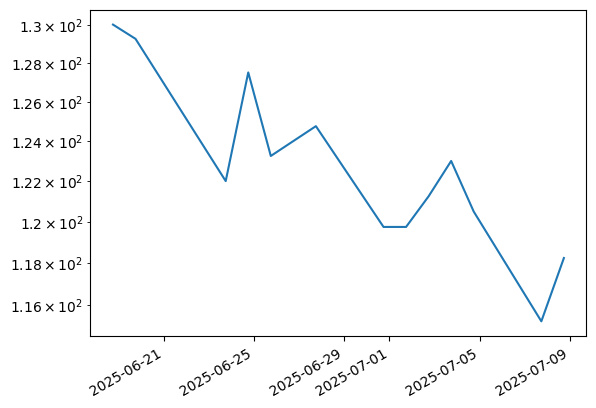

In [13]:
df = get_ticker_wrapper('tv:COME', timeframe='1') #Fuerza TradingView
print(df)
df[-240:-1].Close.plot(logy=True)

Descargando datos de bm_MERV_NVDAD_24hs en timeframe D desde matriz
Resolución en 1
Resolución en D


<Axes: >

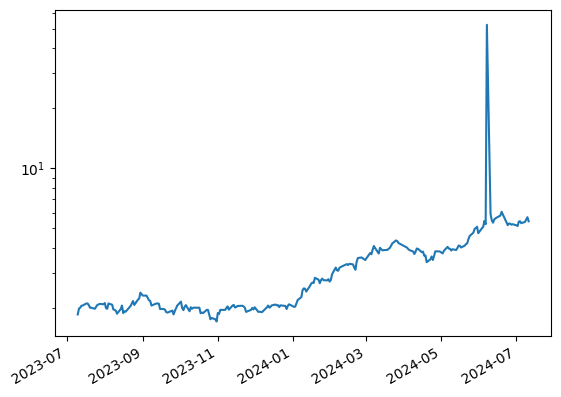

In [ ]:
df = get_ticker_wrapper('bm_MERV_NVDAD_24hs') #Fuerza matriz
df[-240:-1].Close.plot(logy=True)

Descargando datos de bm_MERV_AL30D_24hs en timeframe D desde matriz
Resolución en 1
Resolución en D


<Axes: >

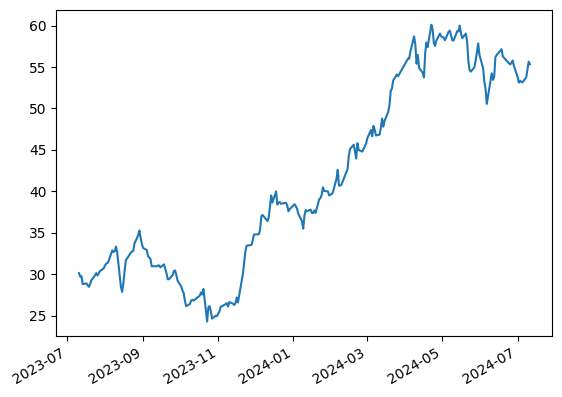

In [ ]:
df = get_ticker_wrapper('bm_MERV_AL30D_24hs') #Fuerza matriz
df[-240:-1].Close.plot()